# ASSIGNMENT 3

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
import xgboost as xgb

<b>a) Import the data from the website directly: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.dataLinks to an external site.

In [3]:
adult_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None, skipinitialspace=True)

In [4]:
list_of_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
adult_df.columns = list_of_columns

<b>c) Check your dataframe shape to verify that you have the correct # of rows and columns. Run the following command:

In [5]:
adult_df.shape

(32561, 15)

<b>d) Drop the 3rd column from the data (it is referred to as "fnlwgt" on UCI's website and is not necessary in this homework)

In [6]:
adult_df = adult_df.drop(['fnlwgt'], axis=1)

<b>e) Note: There are random values of  '?' that show up in the data - this is fine! These just refer to "unknown" and can be left as is. This data has no true NA values, so no need to check.

In [7]:
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   education-num   32561 non-null  int64 
 4   marital-status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  salary          32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


<b>f) Use the .replace() method to make the following changes to the "salary" column:
- "<=50K" should become 0
- ">50K" should become 1

In [8]:
adult_df['salary'] = adult_df['salary'].apply(lambda x: x.replace('<=50K', '0') if x=='<=50K' else '1').astype(int)
adult_df['salary'].head()

0    0
1    0
2    0
3    0
4    0
Name: salary, dtype: int32

<b>g) Create your X dataframe (just your predictors). It should include every feature except for the target variable which is "salary".

In [9]:
X = adult_df.drop(['salary'], axis=1)
X.shape

(32561, 13)

<b>h) Create your y dataframe (just your target variable). It should only be "salary".

In [10]:
y = adult_df['salary']
y.shape

(32561,)

In [11]:
y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: salary, Length: 32561, dtype: int32

<b>i) For this homework we will try converting columns with factors to separate columns (i.e. one-hot encoding). It is not necessary for trees, but can be a very powerful tool to use. There are a variety of ways to do this, but we can use Pandas built-in method .get_dummies(). Pandas will automatically split out columns that are categorical. For now, just run across your full X dataframe.

In [12]:
X_encoded = pd.get_dummies(X)
X_encoded.shape

(32561, 107)

<b>j) Split data into train / test set using an 70/30 split. Verify that you have the same number of columns in your X_train and X_test.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size = 0.7, test_size= 0.3, random_state=42)

In [14]:
X_train.shape, X_test.shape

((22792, 107), (9769, 107))

### 2. Random Forest Classifier - Base Model:

<b>Start by creating a simple Random Forest only using default parameters - this will let us compare Boosting methods to Random Forest in binary classification problems.

a) Use the RandomForestClassifier in sklearn. Fit your model on the training data.

In [15]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

<b>b) Use the fitted model to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [16]:
y_pred = clf.predict(X_test)

In [17]:
y_pred_prob = clf.predict_proba(X_test)

<b>c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

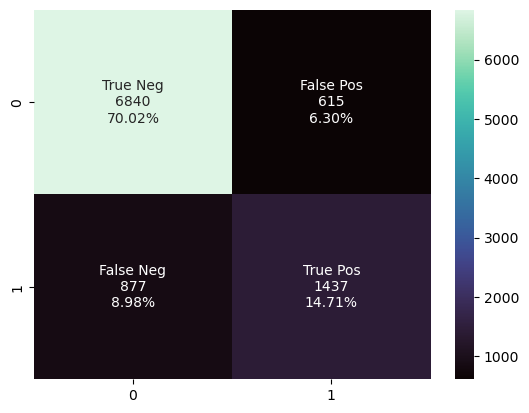

In [18]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='mako')
plt.show()

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      7455
           1       0.70      0.62      0.66      2314

    accuracy                           0.85      9769
   macro avg       0.79      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769



<b>d) Calculate the AUC score.

In [20]:
roc_auc_score(y_test, y_pred_prob[:,1])

0.8884766971173049

<b>e) Identify the top 5 features. Feel free to print a list OR to make a plot.

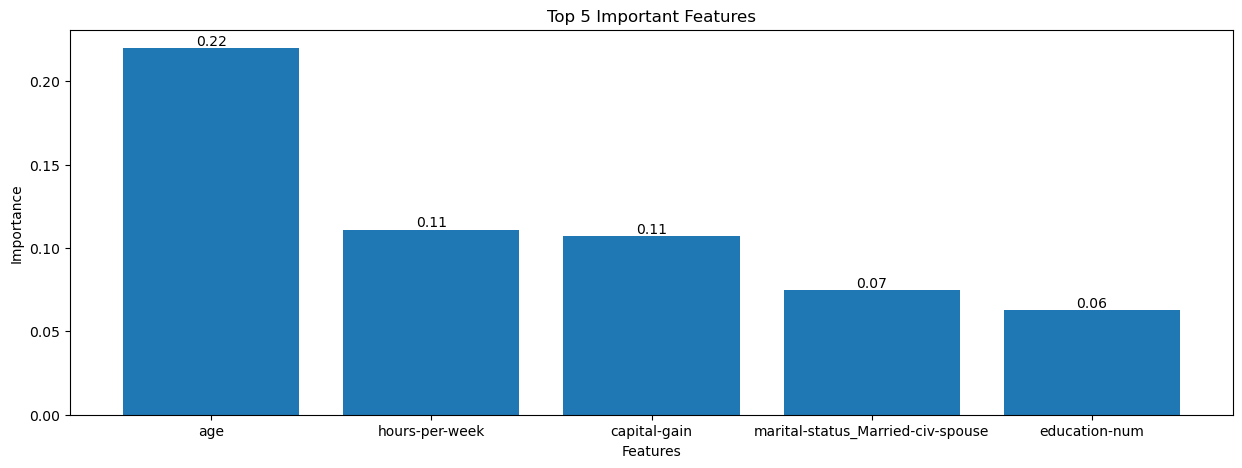

In [21]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X_encoded.columns[indices][:5]

plt.figure(figsize=(15,5))
plt.title("Top 5 Important Features")
bar_plot = plt.bar(range(len(top_features)), importances[indices][:5], align='center')
plt.xticks(range(len(top_features)), top_features)
plt.xlabel("Features")
plt.ylabel("Importance")
for i, v in enumerate(importances[indices][:5]):
    plt.text(i, v, str(round(v,2)), ha='center', va='bottom')
plt.show()

<b>f) Using the model from part B, predict for the train data. Look at the classification report for the train data - is there overfitting for the RandomForest model happening?

In [22]:
y_pred_train = clf.predict(X_train)
y_pred_train

array([0, 1, 0, ..., 0, 0, 0])

In [23]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17265
           1       0.97      0.95      0.96      5527

    accuracy                           0.98     22792
   macro avg       0.98      0.97      0.97     22792
weighted avg       0.98      0.98      0.98     22792



There is overfitting as the model has performed very well on the train data but is not performing well on the test/unseen data.

### 3. AdaBoost Classifier - GridSearch:

<b>Start by creating a simple AdaBoostClassifier only using default parameters.

In [24]:
abc = AdaBoostClassifier()

<b>a) Use the AdaBoostClassifier along with the GridSearchCV tool. Run the GridSearchCV using the following:

n_estimators: 100, 200, 300, 400
learning_rate: 0.2,0.4,0.6,0.8,1, 1.2

In [25]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
parameters = {'n_estimators':[100, 200, 300, 400],
              'learning_rate':[0.2,0.4,0.6,0.8,1, 1.2]}

clf_abc = GridSearchCV(abc, parameters, cv=cv, scoring='roc_auc', n_jobs=-1)
abc1 = clf_abc.fit(X_train,y_train)

<b>b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [26]:
y_pred_abc = abc1.best_estimator_.predict(X_test)
y_pred_abc

array([0, 1, 1, ..., 0, 1, 1])

In [27]:
y_pred_prob_abc = abc1.best_estimator_.predict_proba(X_test)
y_pred_prob_abc

array([[0.50235922, 0.49764078],
       [0.49989469, 0.50010531],
       [0.49971672, 0.50028328],
       ...,
       [0.5027286 , 0.4972714 ],
       [0.49999487, 0.50000513],
       [0.49387416, 0.50612584]])

<b>c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

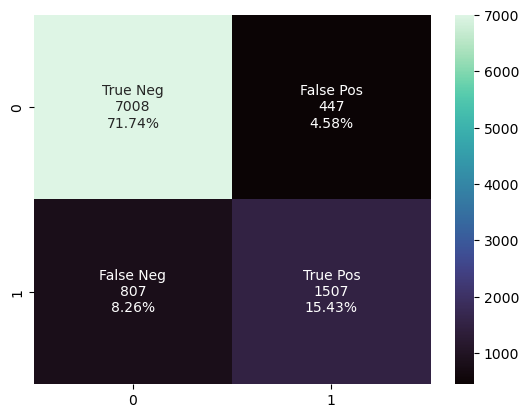

In [28]:
cf_matrix = confusion_matrix(y_test, y_pred_abc)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='mako')
plt.show()

In [29]:
print(classification_report(y_test, y_pred_abc))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.77      0.65      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



<b>d) Calculate the AUC score

In [30]:
roc_auc_score(y_test, y_pred_prob_abc[:,1])

0.9244122180504519

<b>e) Identify the top 5 features. Feel free to print a list OR to make a plot.

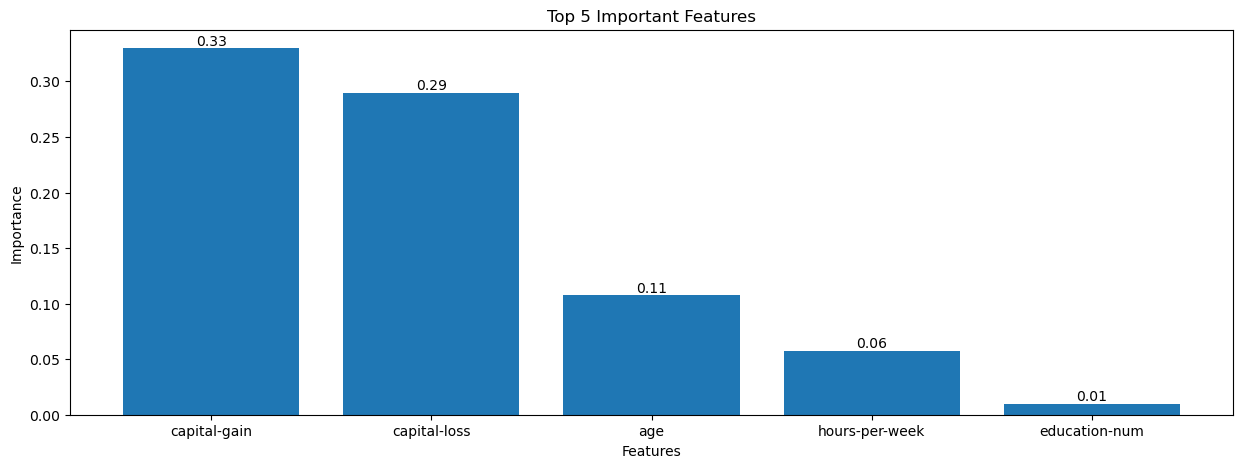

In [31]:
importances = abc1.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X_encoded.columns[indices][:5]

plt.figure(figsize=(15,5))
plt.title("Top 5 Important Features")
bar_plot = plt.bar(range(len(top_features)), importances[indices][:5], align='center')
plt.xticks(range(len(top_features)), top_features)
plt.xlabel("Features")
plt.ylabel("Importance")
for i, v in enumerate(importances[indices][:5]):
    plt.text(i, v, str(round(v,2)), ha='center', va='bottom')
plt.show()

<b>f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

In [32]:
y_pred_train_abc = abc1.best_estimator_.predict(X_train)
y_pred_train_abc

array([0, 1, 0, ..., 0, 0, 0])

In [33]:
print(classification_report(y_train, y_pred_train_abc))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17265
           1       0.78      0.66      0.71      5527

    accuracy                           0.87     22792
   macro avg       0.84      0.80      0.82     22792
weighted avg       0.87      0.87      0.87     22792



There is no overfitting as the model has performed similarly on both the train and test data.

### 4. Gradient Boosting Classifier - GridSearch:

<b>a) Use GradientBoostingClassifier along with the GridSearchCV tool. Run the GridSearchCV using the following hyperparameters:

n_estimators: 100,200, 300 & 400
learning_rate: choose 3 learning rates of your choice
max_depth: 1, 2 (you can try deeper, but remember part of the value of boosting stems from minimal complexity of trees)

In [34]:
gbc = GradientBoostingClassifier()
parameters = {'n_estimators':[100, 200, 300, 400],
              'learning_rate':[0.2,0.6,1],
              'max_depth':[1,2]}

clf_gbc = GridSearchCV(gbc, parameters, cv=cv, scoring='roc_auc', n_jobs=-1)
gbc1 = clf_gbc.fit(X_train,y_train)

<b>b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [35]:
y_pred_gbc = gbc1.best_estimator_.predict(X_test)
y_pred_gbc

array([0, 1, 1, ..., 0, 1, 1])

In [36]:
y_pred_prob_gbc = gbc1.best_estimator_.predict_proba(X_test)
y_pred_prob_gbc

array([[0.99093585, 0.00906415],
       [0.44163911, 0.55836089],
       [0.30868258, 0.69131742],
       ...,
       [0.99219417, 0.00780583],
       [0.46704463, 0.53295537],
       [0.00397438, 0.99602562]])

<b>c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

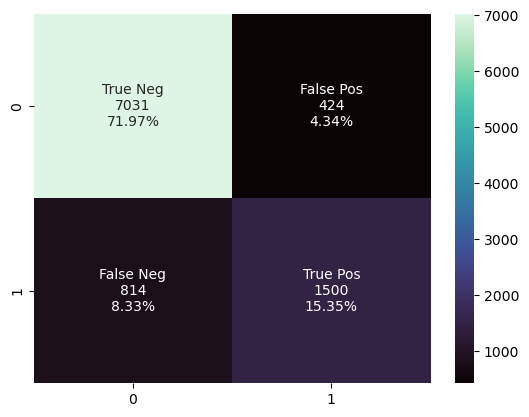

In [37]:
cf_matrix = confusion_matrix(y_test, y_pred_gbc)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='mako')
plt.show()

In [38]:
print(classification_report(y_test, y_pred_gbc))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.78      0.65      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



<b>d) Calculate the AUC score

In [39]:
roc_auc_score(y_test, y_pred_prob_gbc[:,1])

0.9259972685435574

<b>e) Identify the top 5 features. Feel free to print a list OR to make a plot.

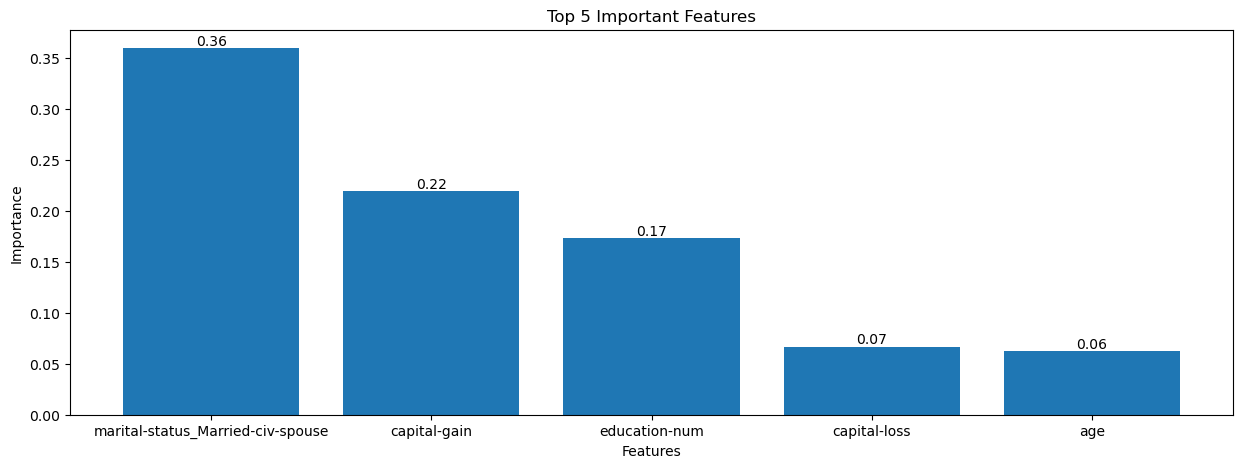

In [40]:
importances = gbc1.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X_encoded.columns[indices][:5]

plt.figure(figsize=(15,5))
plt.title("Top 5 Important Features")
bar_plot = plt.bar(range(len(top_features)), importances[indices][:5], align='center')
plt.xticks(range(len(top_features)), top_features)
plt.xlabel("Features")
plt.ylabel("Importance")
for i, v in enumerate(importances[indices][:5]):
    plt.text(i, v, str(round(v,2)), ha='center', va='bottom')
plt.show()

<b>f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

In [41]:
y_pred_train_gbc = gbc1.best_estimator_.predict(X_train)
y_pred_train_gbc

array([0, 1, 0, ..., 0, 0, 0])

In [42]:
print(classification_report(y_train, y_pred_train_gbc))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     17265
           1       0.81      0.67      0.73      5527

    accuracy                           0.88     22792
   macro avg       0.85      0.81      0.83     22792
weighted avg       0.88      0.88      0.88     22792



There is no overfitting as the model has performed similarly on both the train and test data.

### 5. XGBoost - RandomizedSearchCV

<b>Repeat 4(a) - 4(f) with xgboost and RandomizedSearchCV.

For 4a use the following parameters: 

n_estimators: 100-1000 in increments of 50  (i.e. 100,150,200,.....1000)
learning_rate: 0.1 - 1.6 in increments of 0.1
max_depth: 1, 2
gamma: 0 - 5 in increments of 0.25

In [43]:
xgb_clf = xgb.XGBClassifier()
parameters = {'n_estimators': range(100, 1001, 50),
              'learning_rate': [i/10.0 for i in range(1, 17)],
              'max_depth':[1,2],
              'gamma': [i/4.0 for i in range(0, 21)]}

rs = RandomizedSearchCV(estimator=xgb_clf, param_distributions=parameters, scoring='roc_auc', cv=cv, n_jobs=-1)
rs1 = rs.fit(X_train,y_train)

<b>b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

In [44]:
y_pred_xgb = rs1.best_estimator_.predict(X_test)
y_pred_xgb

array([0, 1, 1, ..., 0, 1, 1])

In [45]:
y_pred_prob_xgb = rs1.best_estimator_.predict_proba(X_test)
y_pred_prob_xgb

array([[9.8962700e-01, 1.0372977e-02],
       [4.7156888e-01, 5.2843112e-01],
       [2.5169647e-01, 7.4830353e-01],
       ...,
       [9.9462795e-01, 5.3720460e-03],
       [4.5778173e-01, 5.4221827e-01],
       [6.4283609e-04, 9.9935716e-01]], dtype=float32)

<b>c) Calculate the confusion matrix and classification report (both are in sklearn.metrics).

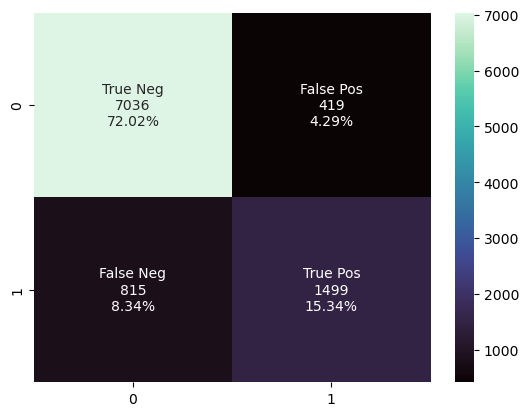

In [46]:
cf_matrix = confusion_matrix(y_test, y_pred_xgb)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='mako')
plt.show()

In [47]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.78      0.65      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



<b>d) Calculate the AUC score

In [48]:
roc_auc_score(y_test, y_pred_prob_xgb[:,1])

0.9261285662694114

<b>e) Identify the top 5 features. Feel free to print a list OR to make a plot.

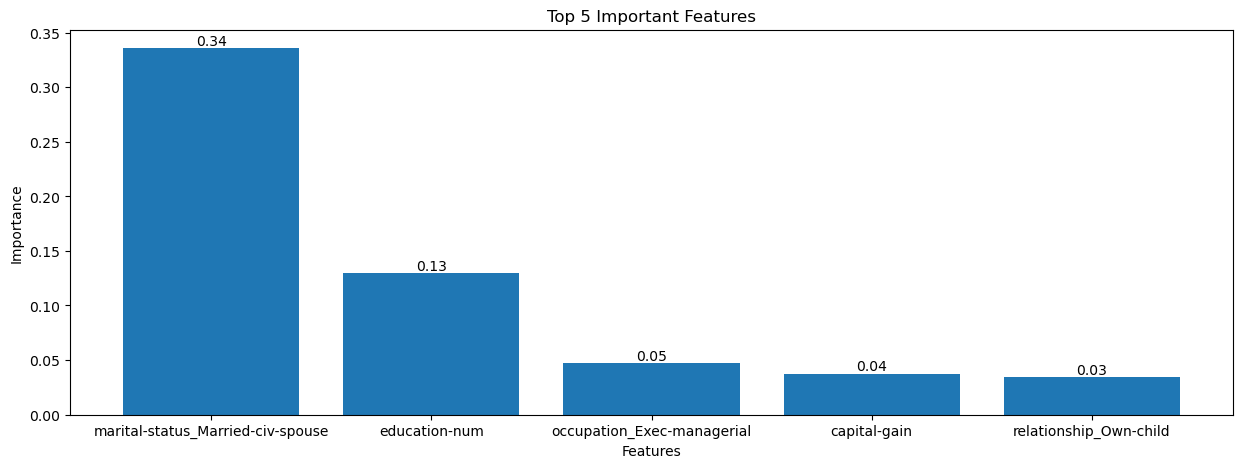

In [49]:
importances = rs1.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X_encoded.columns[indices][:5]

plt.figure(figsize=(15,5))
plt.title("Top 5 Important Features")
bar_plot = plt.bar(range(len(top_features)), importances[indices][:5], align='center')
plt.xticks(range(len(top_features)), top_features)
plt.xlabel("Features")
plt.ylabel("Importance")
for i, v in enumerate(importances[indices][:5]):
    plt.text(i, v, str(round(v,2)), ha='center', va='bottom')
plt.show()

<b>f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

In [50]:
y_pred_train_xgb = rs1.best_estimator_.predict(X_train)
y_pred_train_xgb

array([0, 1, 0, ..., 0, 0, 0])

In [51]:
print(classification_report(y_train, y_pred_train_xgb))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     17265
           1       0.80      0.66      0.72      5527

    accuracy                           0.88     22792
   macro avg       0.85      0.80      0.82     22792
weighted avg       0.87      0.88      0.87     22792



There is no overfitting as the model has performed similarly on both the train and test data.

### 6. Moving into Conceptual Problems:

<b>a) The lecture notes describe the Gini Index which is the default criterion used for splitting in sklearn's version of RandomForestClassifier. How does the Gini Index work? (i.e. How is it used to build a top-performing model?). </b><br>
When building a decision tree, the goal is to create a tree that best separates the data into pure categories, where each category corresponds to a particular class label. The Gini Index is used to measure how well a particular split separates the data into pure categories. The Gini Index is calculated as follows:

$$Gini Index = Σ p_i * (1 - p_i)$$

where $p_i$ is the proportion of data points that belong to class i in the current node. The Gini Index is a measure of impurity because it ranges from 0 to 1, where 0 indicates a perfectly pure node with all data points belonging to the same class, and 1 indicates a maximally impure node with an equal proportion of data points belonging to each class.

When building a decision tree, in order to get a top-performing model, the algorithm considers all possible splits and chooses the split that maximizes the information gain, which is defined as the reduction in the Gini Index from the parent node to the child nodes. In other words, the algorithm chooses the split that results in the greatest improvement in purity. For example, in a RandomForestClassifier model, the algorithm builds multiple decision trees using a random subset of the features and data points. The final prediction is based on the majority vote of the predictions made by each individual decision tree. The use of multiple trees reduces the risk of overfitting and improves the generalization performance of the model.

<b>b) Describe how Random Forest is different from bagging & why this difference can yield improved results.</b><br>
Random Forest is a specific type of ensemble learning method based on decision trees that is different from the traditional bagging algorithm where Bagging builds multiple independent models on different bootstrapped samples of the data and then averages their predictions to make a final prediction. On the other hand, Random Forest builds multiple decision trees on bootstrapped samples of the data, but with a key difference - at each split, instead of considering all features to split on, Random Forest selects a random subset of features to consider. This helps to reduce the correlation among the trees and prevent overfitting. In addition, each tree is trained on a different subset of the data, further increasing the diversity of the models.

As a result of this difference, Random Forest can often yield improved results over a single decision tree or bagging by combining the predictions of multiple, diverse decision trees. It is especially useful in high-dimensional datasets where there may be many features that are irrelevant or redundant.

<b>c) Describe the importance of the max_depth parameter in Random Forest. Do not just provide a definition, rather think through how bias-variance tradeoff might be impacted by the max_depth parameter.</b><br>
The max_depth parameter in Random Forest controls the depth of the decision trees in the forest. It specifies the maximum number of levels in the tree, which in turn controls the complexity of the model.
- A lower max_depth value would result in simpler trees, which would have less variance and higher bias. Such trees may lead to underfitting. 
- A higher max_depth value would result in complex trees that can fit the training data better, but may also overfit the data by capturing noise in the training data, resulting in poor performance on the test data.<br>
A good way to find the optimal max_depth value is to try different values and evaluate the performance of the model on the test data using a validation set or cross-validation.

<b>d) What does the alpha parameter represent in AdaBoost? Please refer to chapter 7 of the Hands-On ML book if you are struggling.</b><br>
The alpha parameter in AdaBoost represents the contribution of each predictor in the ensemble. The predictors are weighted based on their overall accuracy and the alpha value is used to calculate the weight of each predictor in the final prediction. Predictors with high accuracy are assigned a higher weight, whereas those with lower accuracy are assigned a lower weight. It is calculated with the below formula: $$α_j = η log (1-r_j/r_j) $$

<b>e) In AdaBoost explain how the final predicted class is determined. Be sure to reference the alpha term in your explanation.</b><br>
In AdaBoost, each individual weak learner is trained on the dataset and given a weight. During prediction, the weak learners are combined and their contributions to the final prediction are weighted based on their individual accuracy, with higher weight given to more accurate learners. The alpha term represents the weight of each individual weak learner's contribution to the final prediction.
The final predicted class is determined by taking a weighted majority vote of the individual weak learners' predictions, with the weights being determined by the alpha values. The predicted class is the one with the highest weighted vote.

<b>f) In Gradient Boosting, what is the role of the max_depth parameter? Why is it important to tune on this parameter?</b><br>
In Gradient Boosting, the max_depth parameter controls the depth of individual decision trees in the ensemble. It limits the number of nodes in a single decision tree and the complexity of the model. 
- If the max_depth is set too high, the model might overfit the training data, resulting in poor generalization performance on unseen data. 
- If the max_depth is set too low, the model might underfit the training data, resulting in high bias and poor accuracy.<br>
Therefore, it is essential to tune the max_depth parameter to find the optimal value that balances the bias-variance tradeoff and achieves the best performance on the validation set. A common approach is to perform a grid search or a randomized search over a range of possible max_depth values and choose the one that produces the best results.

<b>g) In Part (e) of Steps 2-5 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if this predictor makes sense given what you are attempting to predict. (Note: If you don't have any predictors showing up across all 3 predictors, explain one that shows up in 2 of them).</b><br>
The predictors appearing across the models (Random Forest, AdaBoost, Gradient Boost) are:
- age: Given that as age increases and the experience increases, the salary is bound to be determined by this.
- capital gain: The more capital an individual earns, the higher their salary is likely to be.<br>
- education-num: Education is often an important qualification for many jobs, and higher levels of education are often associated with higher salaries.

<b>h) From the models run in steps 2-5, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyperparameters found from your grid search.</b><br>
The classification report for the models reveals that the dataset is imbalanced, with a support of 7455 for cases with less than 50K salary and 2314 cases otherwise. Amongst all the models, Random Forest has the lowest precision, recall, and f1-scores, making it the worst-performing model. When considering the class 0 and 1 predictions, the precision, recall, and f1-scores are the same for AdaBoosting, GradientBoosting, and XGBoost, with GradientBoost having a slightly higher score than the other two. However, this difference is not significant enough to make a decision on which is the best performing model. Therefore, when looking at the macro average, it can be observed that GradientBoosting has a higher value of precision and recall, followed by AdaBoosting and XGBoost, respectively. Hence, GradientBoosting is the best performing model.

The optimal hyperparameters for Grid Search using GradientBoosting are:

In [52]:
gbc1.best_estimator_

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=400)

<b>i) For your best performing model, plot out a ROC curve using your test data. Feel free to use sklearn, matplotlib or any other method in python. Describe what the x-axis & y-axis of the ROC curve tell us about a classifier.</b><br>

c:\Users\Administrator\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


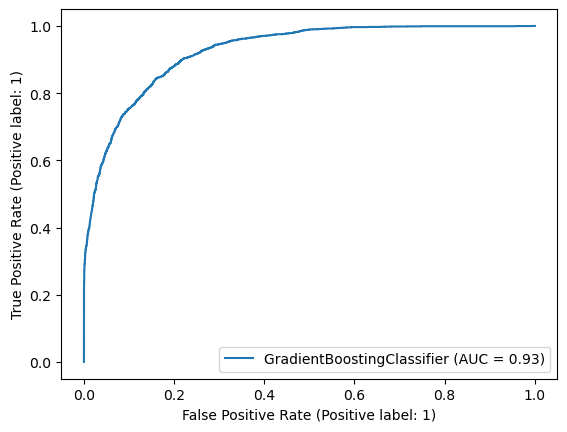

In [53]:
plot_roc_curve(gbc1.best_estimator_, X_test, y_test)

The x-axis of the ROC curve represents the False Positive Rate (FPR), which is the ratio of negative instances that are incorrectly classified as positive. Mathematically, $$FPR = FP / (TN + FP)$$ where FP is the number of false positives and TN is the number of true negatives.

The y-axis of the ROC curve represents the True Positive Rate (TPR), which is the ratio of positive instances that are correctly classified as positive. Mathematically, $$TPR = TP / (TP + FN)$$ where TP is the number of true positives and FN is the number of false negatives.
The ROC curve shows the tradeoff between the TPR and FPR for different classification thresholds. A good classifier will have a curve that is close to the top-left corner, which corresponds to high TPR and low FPR. The area under the ROC curve (AUC) is a measure of the overall performance of the classifier, with higher AUC indicating better performance.